Envoyer à nicolas.salvy@inria.fr
\
LSD_TP2_Name1_Name2
\
Deadline January 23rd pour part 1 et part 2 ensemble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Generation of synthetic data

In [2]:
Tmin=1
Tmax=1000
N=200

def T(n, N, Tmin, Tmax):
    return Tmin*np.exp(-(n-1)*np.log(Tmin/Tmax)/(N-1))

T_values = [T(n, N, Tmin, Tmax) for n in range(1, N+1)]

In [3]:
with open('signal.txt', 'r') as file:
    original_signal = file.read()

original_signal = list(map(float, original_signal.split()))
x = pd.DataFrame(original_signal, index=T_values, columns=['Valeur'])

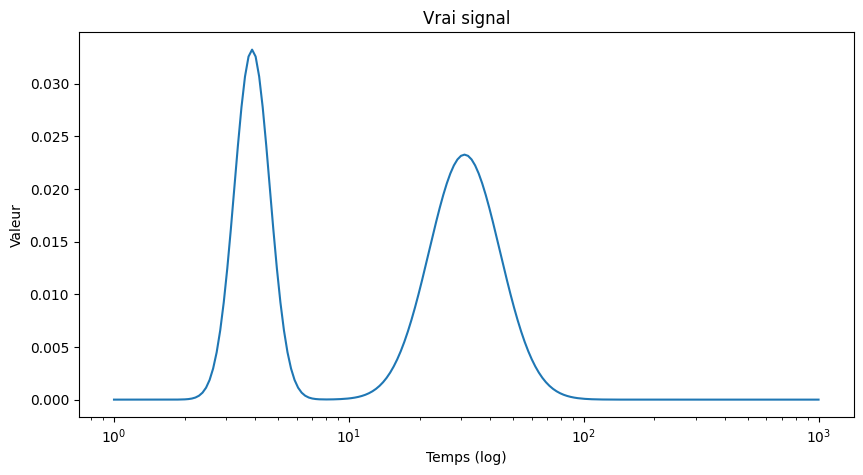

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(x)
plt.xscale('log')
plt.title('Vrai signal')
plt.ylabel('Valeur')
plt.xlabel('Temps (log)')
plt.show()

In [5]:
M=50
tmin=0
tmax=1.5

def t(m, M, tmin, tmax):
    return tmin + (m-1)*(tmax-tmin)/(M-1)

t_values = [t(m, M, tmin, tmax) for m in range(1, M+1)]


In [6]:
K = np.exp(-np.outer(t_values, T_values))

In [7]:
z = K @ x.values
sigma = 0.01*z[0]
w = np.random.normal(0, sigma, M).reshape(-1, 1)

noisy_signal = z + w
noisy_signal_df = pd.DataFrame(noisy_signal, index=t_values, columns=['Valeur'])

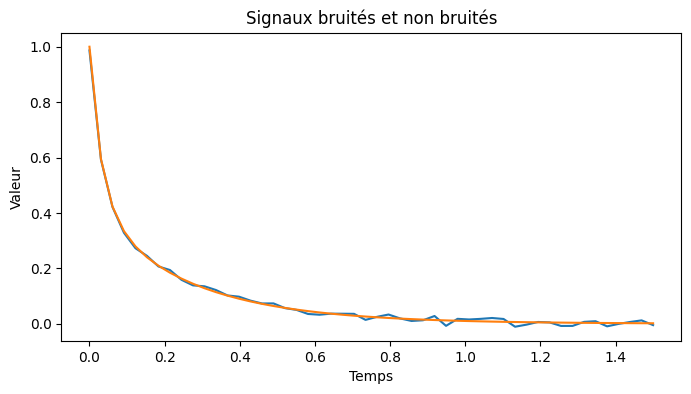

In [8]:
plt.figure(figsize=(8,4))
plt.plot(t_values, noisy_signal_df, label='Signal bruité')
plt.plot(t_values, z, label='Signal originel')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.show()

## Comparison of regularization strategies

$ x = \argmin  \frac{1}{2} \|Kx-y\|^2 + \beta g(x) $

On pose $G(x) = \frac{1}{2} \|Kx-y\|^2 + \beta g(x) $

## Smoothness prior : 
$$g(x) = \frac{1}{2} \|Dx\|^2 $$

$R^N$ est convexe. 
G est continue et coercive, il existe donc un minimum. 
De plus, G est strictment convexe, il y a donc unicité de ce minimum.

On peut résoudre explicitement ce problème de minimisation.

$\nabla G(x) = K^T(Kx - y) + \beta D^TDx$

Ainsi, le $x$ optimal, annulant ce gradient est :
$x_{min} = (K^TK + \beta D^TD)^{-1}K^Ty$

In [9]:
from scipy.linalg import circulant, inv

D = np.zeros(N)
c = np.zeros(N)
c[0] = 1
c[1] = -1
D = circulant(c)

def smoothness_prior(y, beta):
    matr = K.T @ K + beta * D.T @ D
    return inv(matr) @ K.T @ y

x_opt = smoothness_prior(noisy_signal, 0.1)

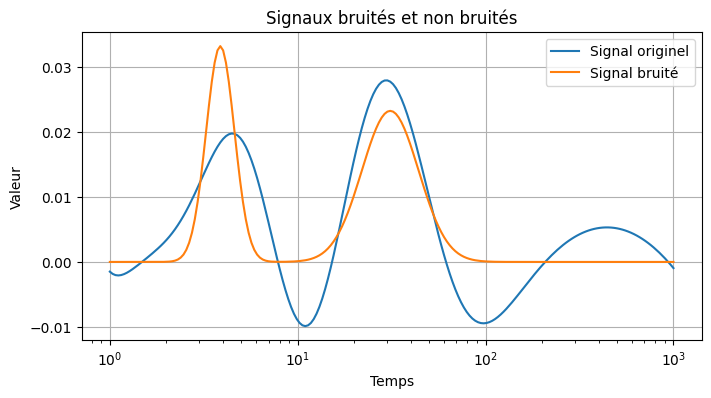

In [10]:
plt.figure(figsize=(8,4))
plt.plot(T_values, x_opt, label='Signal originel')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

In [11]:
def error(x, x_opt):
    num = np.linalg.norm(x - x_opt)**2
    denom = np.linalg.norm(x)**2
    return num/denom

print(f'Normalized quadratic error: {error(x.values, x_opt):2f}')

Normalized quadratic error: 0.354416


Best beta: 0.37 Error: 0.15


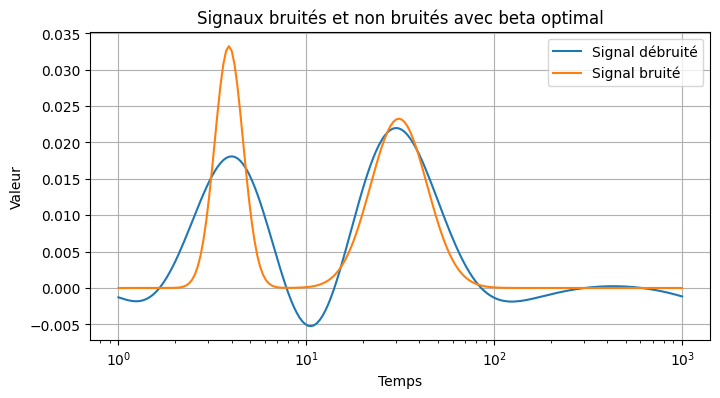

In [13]:
beta_values = np.logspace(-3, 3, 50)  # Test beta values from 0.001 to 1000
errors = []

for beta in beta_values:
    x_opt = smoothness_prior(noisy_signal, beta)
    quadratic_err = error(x.values, x_opt)
    errors.append(quadratic_err)

best_beta = beta_values[np.argmin(errors)]
best_signal = smoothness_prior(noisy_signal, best_beta)
associated_error = error(x.values, best_signal)
print(f'Best beta: {best_beta:.2f}', f'Error: {associated_error:.2f}')

plt.figure(figsize=(8,4))
plt.plot(T_values, best_signal, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités avec beta optimal')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

## Smoothness prior + constraints :



$ g(x) = \frac{1}{2} \|Dx\|^2 + ι_{[x_{min}, x_{max}]^N} (x) $

Contrainte ajoutée : $ x \in [x_{min}, x_{max}]^N $

L'ensemble de départ est un ensemble fermé borné de  $R^N$. G y est continue, il existe donc un minimum.
 
De plus, G est strictment convexe, il y a donc unicité de ce minimum.

Pour résoudre ce problème, on utilise l'algorithme du gradient projeté, car $ x \in [x_{min}, x_{max}]^N $ est un ensemble fermé convexe.

$\nabla G(x) = K^T(Kx - y) + \beta D^TDx$

Ce gradient est lipschitzien, de constante $||K||^2 + \beta ||D||^2$


In [14]:
def gradient_g(y, x, beta):
    matr = K.T @ K + beta * D.T @ D
    return matr @ x - K.T @ y

def gradient_g_for_descent(y, x, matr):
    return matr @ x - K.T @ y

def gradient_projete(y, x0, beta, max_iter=10000, threshold=1e-6):
    # Initialisation des paramètres :
    x_curr = x0
    xmin = np.min(x.values)
    xmax = np.max(x.values)
    L = np.linalg.norm(K, ord=2)**2 + beta * np.linalg.norm(D, ord=2)**2
    gamma = 1.5/L
    delta = 2-gamma*L/2
    lambd = delta/2

    matr = K.T @ K + beta * D.T @ D

    for iter in range(max_iter):
        gradient = gradient_g_for_descent(y, x_curr, matr)
        z = np.clip(x_curr - gamma * gradient, xmin, xmax)
        x_curr += lambd * (z - x_curr)
        if np.linalg.norm(gradient) < threshold:
            print(f'Convergence atteinte en {iter} itérations')
            break
    return x_curr

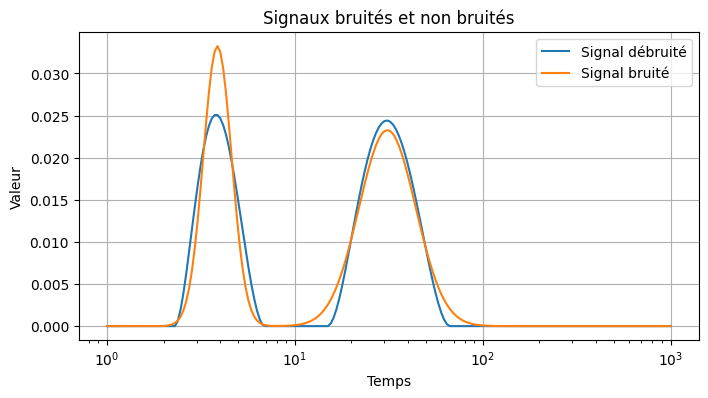

In [15]:
x0 = np.zeros(N).reshape(-1, 1)
x_opt = gradient_projete(noisy_signal, x0, 0.5, 50000)

plt.figure(figsize=(8,4))
plt.plot(T_values, x_opt, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

Évaluation des erreurs: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Best beta: 0.339 Error: 0.03


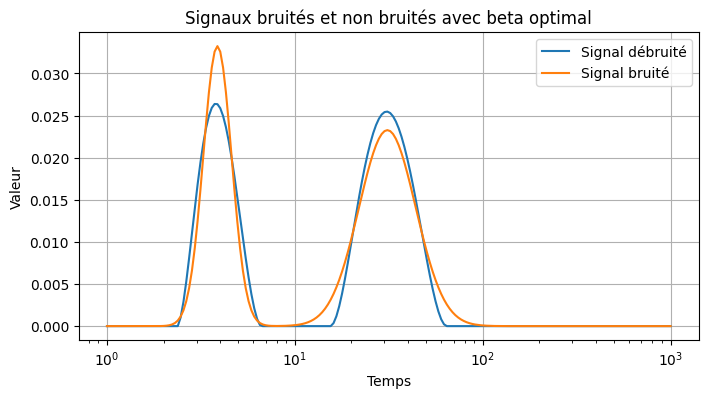

In [16]:
beta_values = np.logspace(-3, 1, 50)  # Test beta values from 0.001 to 1000
errors = []

for beta in tqdm.tqdm(beta_values, desc="Évaluation des erreurs"):
    x_opt = gradient_projete(noisy_signal, x0, beta, 50000)
    quadratic_err = error(x.values, x_opt)
    errors.append(quadratic_err)

best_beta = beta_values[np.argmin(errors)]
best_signal = gradient_projete(noisy_signal, x0, best_beta, 50000)
associated_error = error(x.values, best_signal)
print(f'Best beta: {best_beta:.3f}', f'Error: {associated_error:.2f}')

plt.figure(figsize=(8,4))
plt.plot(T_values, best_signal, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités avec beta optimal')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

## Sparsity prior :



$∀x \in R^N, g(x) = ||x||_1$

$R^N$ est convexe. 
G est continue et coercive, il existe donc un minimum. 
De plus, G est strictment convexe, il y a donc unicité de ce minimum.

Algorithme du gradient projeté :

G est lipschitzienne de constante $L = ||K||^2 + \beta$

In [19]:
def gradient_g_sparse(x, beta, KTK, matr_y):
    return KTK @ x - matr_y + beta * np.sign(x)

def gradient_projete_sparse(y, x0, beta, max_iter=50000, threshold=1e-6):
    # Initialisation des paramètres :
    x_curr = x0
    L = np.linalg.norm(K, ord=2)**2 + beta
    gamma = 1.5/L
    delta = 2-gamma*L/2
    lambd = delta/2

    KTK = K.T @ K
    matr_y = K.T @ y
    for iter in range(max_iter):
        gradient = gradient_g_sparse(x_curr, beta, KTK, matr_y)
        z = x_curr - gamma * gradient
        x_curr += lambd * (z - x_curr)
        if np.linalg.norm(gradient) < threshold:
            print(f'Convergence atteinte en {iter} itérations')
            break
    return x_curr

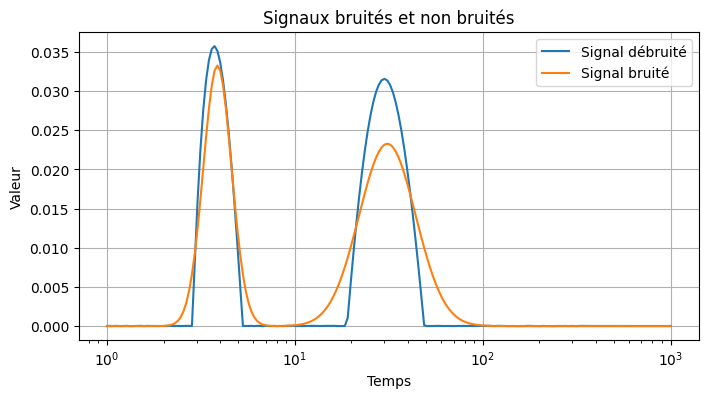

In [ ]:
x0 = np.zeros(N).reshape(-1, 1)
x_opt = gradient_projete_sparse(noisy_signal, x0, 0.01, 50000, 1e-8)

plt.figure(figsize=(8,4))
plt.plot(T_values, x_opt, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

Évaluation des erreurs: 100%|██████████| 50/50 [03:11<00:00,  3.82s/beta]


Best beta: 0.043 Error: 0.17


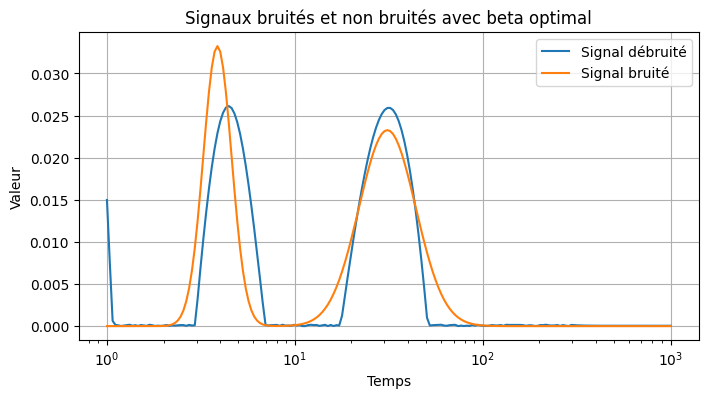

In [69]:
beta_values = np.logspace(-3, 1, 50)  # Test beta values from 0.001 to 1
errors = []

for beta in tqdm.tqdm(beta_values, desc="Évaluation des erreurs"):
    x_opt = gradient_projete_sparse(noisy_signal, x0, beta, 50000, 1e-8)
    quadratic_err = error(x.values, x_opt)
    errors.append(quadratic_err)

best_beta = beta_values[np.argmin(errors)]
best_signal = gradient_projete_sparse(noisy_signal, x0, best_beta, 50000, 1e-8)
associated_error = error(x.values, best_signal)
print(f'Best beta: {best_beta:.3f}', f'Error: {associated_error:.2f}')

plt.figure(figsize=(8,4))
plt.plot(T_values, best_signal, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités avec beta optimal')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()